In [ ]:
!pip install split-folders --quiet

In [ ]:
# ==============================================================================
# SECTION 0: IMPORT SEMUA LIBRARY YANG DIBUTUHKAN
# ==============================================================================
# Standard & Data Handling
import os
import shutil
import zipfile
import time
import numpy as np
import pandas as pd
from PIL import Image
import joblib
import re # Untuk parsing jika diperlukan

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Kaggle & Drive
from google.colab import drive
import kagglehub

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split # Hanya untuk split train/val/test awal jika diperlukan
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder # OneHotEncoder untuk ROC
import splitfolders # Untuk membagi dataset gambar

# GLM dari statsmodels
import statsmodels.api as sm

# Metrics & Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Pastikan semua instalasi ada di awal jika diperlukan
!pip install kagglehub --quiet --upgrade
!pip install split-folders --quiet
!pip install statsmodels --quiet --upgrade
!pip install scikit-learn --quiet --upgrade

print(f"Semua library dasar untuk GLM OvR (statsmodels) siap. (Tanggal: {time.strftime('%Y-%m-%d %H:%M:%S')})")

Semua library dasar untuk GLM OvR (statsmodels) siap. (Tanggal: 2025-05-07 14:32:13)


In [ ]:
# ==============================================================================
# SECTION 1: SETUP DAN MOUNT GOOGLE DRIVE
# ==============================================================================
print("\n--- SECTION 1: Setup dan Mount Google Drive ---")
try:
    drive.mount('/content/drive')
    print("Google Drive berhasil di-mount.")
except Exception as e:
    print(f"Error saat mounting Google Drive: {e}")

# Definisikan path proyek
PROJECT_NAME = "ProyekGLM_OvR_Makanan" # Nama baru
BASE_DRIVE_PATH = "/content/drive/MyDrive"
PROJECT_PATH = os.path.join(BASE_DRIVE_PATH, PROJECT_NAME)
DATASET_PATH = os.path.join(PROJECT_PATH, "datasets_glm_ovr")
RAW_DATA_PATH = os.path.join(DATASET_PATH, "raw_food_img_glm_ovr")
PROCESSED_DATA_PATH = os.path.join(DATASET_PATH, "processed_glm_ovr")
MODEL_PATH = os.path.join(PROJECT_PATH, "models_glm_ovr")
RESULTS_PATH = os.path.join(PROJECT_PATH, "results_glm_ovr")

os.makedirs(PROJECT_PATH, exist_ok=True)
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"Folder proyek '{PROJECT_NAME}' telah disiapkan di: {PROJECT_PATH}")


--- SECTION 1: Setup dan Mount Google Drive ---
Error saat mounting Google Drive: mount failed
Folder proyek 'ProyekGLM_OvR_Makanan' telah disiapkan di: /content/drive/MyDrive/ProyekGLM_OvR_Makanan


In [ ]:
# ==============================================================================
# SECTION 2: DOWNLOAD DATASETS GAMBAR DARI KAGGLE DAN STAGING
# (Menggunakan kode yang sudah berfungsi dari interaksi sebelumnya untuk 'faldoae/padangfood')
# ==============================================================================
print("\n--- SECTION 2: Unduh Dataset Gambar Makanan ('faldoae/padangfood') dan Staging ---")

KAGGLE_DATASET_IDENTIFIER = 'faldoae/padangfood'
DATASET_FOLDER_NAME_ON_DRIVE = KAGGLE_DATASET_IDENTIFIER.split('/')[-1] + "_glm_ovr"
temp_colab_base_path = "/content/kaggle_food_temp_glm_ovr" # Area kerja sementara

# --- Fungsi Helper (display_folder_structure, find_actual_data_root - definisi sama spt sebelumnya) ---
def display_folder_structure(root_dir, title="Folder Structure", max_depth=2, max_files_per_folder=3):
    print(f"\n--- {title} ({root_dir}) ---")
    if not os.path.isdir(root_dir): print("  Direktori tidak ditemukan."); return
    # Implementasi lengkap ada di kode sebelumnya... (Disingkat di sini)
    print(f"  (Struktur folder untuk {os.path.basename(root_dir)} akan ditampilkan di sini...)")
    print("-" * 40)

def find_actual_data_root(current_path, min_expected_class_folders=2, current_depth=0, max_search_depth=2):
    print(f"  [find_actual_data_root] Menganalisis path: '{current_path}' (kedalaman: {current_depth})")
    if not os.path.isdir(current_path) or current_depth > max_search_depth: return current_path # Fallback
    items = [item for item in os.listdir(current_path) if item not in ['__MACOSX', '.DS_Store', '.ipynb_checkpoints']]
    item_paths = [os.path.join(current_path, item) for item in items]
    subdirectories = [p for p in item_paths if os.path.isdir(p)]
    if len(subdirectories) >= min_expected_class_folders: return current_path
    if len(subdirectories) == 1 and (len(items) == 1 or all(os.path.isfile(p) for p in item_paths if p != subdirectories[0])):
        return find_actual_data_root(subdirectories[0], min_expected_class_folders, current_depth + 1, max_search_depth)
    return current_path

image_dataset_path_drive = None # Path gambar di Google Drive
if os.path.exists(temp_colab_base_path):
    print(f"Membersihkan area kerja sementara sebelumnya: {temp_colab_base_path}")
    shutil.rmtree(temp_colab_base_path)
os.makedirs(temp_colab_base_path, exist_ok=True)

try:
    print(f"Memanggil kagglehub.dataset_download('{KAGGLE_DATASET_IDENTIFIER}')...")
    dataset_base_uri_from_kaggle = kagglehub.dataset_download(KAGGLE_DATASET_IDENTIFIER)
    print(f"Dataset tersedia dari Kaggle Hub di URI (read-only): {dataset_base_uri_from_kaggle}")
    path_to_inspect_for_data = dataset_base_uri_from_kaggle
    current_data_to_process = None
    potential_zip_name = "archive.zip"
    zip_file_in_kaggle_path = os.path.join(path_to_inspect_for_data, potential_zip_name)

    if os.path.isfile(zip_file_in_kaggle_path):
        print(f"File zip '{potential_zip_name}' ditemukan. Mengekstrak...")
        extraction_folder_name = os.path.splitext(potential_zip_name)[0]
        temp_extraction_output_path = os.path.join(temp_colab_base_path, "extracted_data", extraction_folder_name)
        if os.path.exists(temp_extraction_output_path): shutil.rmtree(temp_extraction_output_path)
        os.makedirs(temp_extraction_output_path, exist_ok=True)
        with zipfile.ZipFile(zip_file_in_kaggle_path, 'r') as zip_ref:
            zip_ref.extractall(temp_extraction_output_path)
        print(f"Ekstraksi selesai ke: {temp_extraction_output_path}")
        current_data_to_process = temp_extraction_output_path
    elif os.path.isdir(path_to_inspect_for_data):
        print(f"Tidak ada zip '{potential_zip_name}'. Menggunakan path '{path_to_inspect_for_data}'.")
        current_data_to_process = path_to_inspect_for_data
    else:
        raise FileNotFoundError(f"Path dari Kaggle Hub ('{dataset_base_uri_from_kaggle}') tidak valid.")

    if not current_data_to_process: raise Exception("Gagal menentukan path data.")

    print(f"\nMencari root data aktual di dalam: '{current_data_to_process}'...")
    actual_data_source_path = find_actual_data_root(current_data_to_process)
    print(f"Root data aktual: '{actual_data_source_path}'")

    final_destination_on_drive = os.path.join(RAW_DATA_PATH, DATASET_FOLDER_NAME_ON_DRIVE)
    print(f"\Menyalin data dari '{actual_data_source_path}' ke '{final_destination_on_drive}'...")
    if os.path.exists(final_destination_on_drive): shutil.rmtree(final_destination_on_drive)
    if not os.path.exists(actual_data_source_path): raise FileNotFoundError(f"Sumber '{actual_data_source_path}' tidak ada.")
    shutil.copytree(actual_data_source_path, final_destination_on_drive)
    print("Data berhasil disalin ke Google Drive.")
    image_dataset_path_drive = final_destination_on_drive
except Exception as e:
    print(f"Error pada SECTION 2: {e}")
    import traceback; traceback.print_exc()

if image_dataset_path_drive and os.path.exists(image_dataset_path_drive):
    print(f"\nVerifikasi Dataset di Google Drive: '{image_dataset_path_drive}'")
    display_folder_structure(image_dataset_path_drive, title=f"Struktur Folder '{DATASET_FOLDER_NAME_ON_DRIVE}' di GDrive", max_depth=1)
else:
    print("\nDataset gambar tidak berhasil disiapkan di Google Drive.")
print("\n--- SECTION 2 Selesai ---")


--- SECTION 2: Unduh Dataset Gambar Makanan ('faldoae/padangfood') dan Staging ---
Memanggil kagglehub.dataset_download('faldoae/padangfood')...
Dataset tersedia dari Kaggle Hub di URI (read-only): /kaggle/input/padangfood
Tidak ada zip 'archive.zip'. Menggunakan path '/kaggle/input/padangfood'.

Mencari root data aktual di dalam: '/kaggle/input/padangfood'...
  [find_actual_data_root] Menganalisis path: '/kaggle/input/padangfood' (kedalaman: 0)
  [find_actual_data_root] Menganalisis path: '/kaggle/input/padangfood/dataset_padang_food' (kedalaman: 1)
Root data aktual: '/kaggle/input/padangfood/dataset_padang_food'
\Menyalin data dari '/kaggle/input/padangfood/dataset_padang_food' ke '/content/drive/MyDrive/ProyekGLM_OvR_Makanan/datasets_glm_ovr/raw_food_img_glm_ovr/padangfood_glm_ovr'...
Data berhasil disalin ke Google Drive.

Verifikasi Dataset di Google Drive: '/content/drive/MyDrive/ProyekGLM_OvR_Makanan/datasets_glm_ovr/raw_food_img_glm_ovr/padangfood_glm_ovr'

--- Struktur Folder

In [ ]:
# ==============================================================================
# SECTION 3: LOAD DATA GAMBAR DAN SPLIT DATASETS (UNTUK KLASIFIKASI)
# ==============================================================================
print("\n--- SECTION 3: Load Data Gambar dan Split untuk Klasifikasi ---")

IMAGE_DATA_SOURCE_PATH_CLF = image_dataset_path_drive
SPLIT_OUTPUT_PATH_CLF = os.path.join(PROCESSED_DATA_PATH, "split_data_glm_ovr_clf") # Folder split khusus

X_train_img, y_train_clf, X_val_img, y_val_clf, X_test_img, y_test_clf = [np.array([])]*6
le_clf = None # LabelEncoder

if IMAGE_DATA_SOURCE_PATH_CLF and os.path.isdir(IMAGE_DATA_SOURCE_PATH_CLF):
    try:
        print(f"Membagi folder gambar dari: {IMAGE_DATA_SOURCE_PATH_CLF}...")
        if os.path.exists(SPLIT_OUTPUT_PATH_CLF): shutil.rmtree(SPLIT_OUTPUT_PATH_CLF)
        os.makedirs(SPLIT_OUTPUT_PATH_CLF, exist_ok=True)
        splitfolders.ratio(IMAGE_DATA_SOURCE_PATH_CLF, output=SPLIT_OUTPUT_PATH_CLF,
                           seed=42, ratio=(.8, .1, .1), group_prefix=None)
        print("Dataset di-split menjadi folder train, val, dan test.")

        IMG_WIDTH, IMG_HEIGHT = 64, 64

        def load_flattened_images_for_classification(folder_path, target_size=(IMG_WIDTH, IMG_HEIGHT), existing_encoder=None):
            images_list, labels_list = [], []
            class_names_from_folders = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
            if not class_names_from_folders: return np.array([]), np.array([]), existing_encoder if existing_encoder else LabelEncoder()
            local_le = existing_encoder if existing_encoder else LabelEncoder().fit(class_names_from_folders)
            print(f"  Folder: {os.path.basename(folder_path)}, Kelas: {list(local_le.classes_)}")
            for class_name in local_le.classes_:
                class_path = os.path.join(folder_path, class_name)
                if not os.path.isdir(class_path): continue
                for img_name in os.listdir(class_path):
                    try:
                        img_path = os.path.join(class_path, img_name)
                        img = Image.open(img_path).convert('L').resize(target_size)
                        images_list.append(np.array(img).flatten())
                        labels_list.append(class_name)
                    except Exception as e: print(f"    Error load {img_path}: {e}")
            if not images_list: return np.array([]), np.array([]), local_le
            return np.array(images_list), local_le.transform(labels_list), local_le

        print("\nMemuat data training...")
        X_train_img, y_train_clf, le_clf = load_flattened_images_for_classification(os.path.join(SPLIT_OUTPUT_PATH_CLF, "train"))
        print(f"Training: {X_train_img.shape[0]} sampel. Label unik: {np.unique(y_train_clf)}")
        print("\nMemuat data validasi...")
        X_val_img, y_val_clf, _ = load_flattened_images_for_classification(os.path.join(SPLIT_OUTPUT_PATH_CLF, "val"), existing_encoder=le_clf)
        print(f"Validasi: {X_val_img.shape[0]} sampel. Label unik: {np.unique(y_val_clf if y_val_clf.size > 0 else [])}")
        print("\nMemuat data testing...")
        X_test_img, y_test_clf, _ = load_flattened_images_for_classification(os.path.join(SPLIT_OUTPUT_PATH_CLF, "test"), existing_encoder=le_clf)
        print(f"Testing: {X_test_img.shape[0]} sampel. Label unik: {np.unique(y_test_clf if y_test_clf.size > 0 else [])}")
        if le_clf: print(f"\nKelas (LabelEncoder): {list(le_clf.classes_)} -> {list(range(len(le_clf.classes_)))}")
        if X_train_img.size == 0: print("PERINGATAN: Tidak ada data training.")

    except Exception as e: print(f"Error Section 3: {e}"); import traceback; traceback.print_exc()
else: print("Path dataset gambar tidak valid.")
print("\n--- SECTION 3 Selesai ---")


--- SECTION 3: Load Data Gambar dan Split untuk Klasifikasi ---
Membagi folder gambar dari: /content/drive/MyDrive/ProyekGLM_OvR_Makanan/datasets_glm_ovr/raw_food_img_glm_ovr/padangfood_glm_ovr...


Copying files: 993 files [00:00, 1288.57 files/s]


Dataset di-split menjadi folder train, val, dan test.

Memuat data training...
  Folder: train, Kelas: [np.str_('ayam_goreng'), np.str_('ayam_pop'), np.str_('daging_rendang'), np.str_('dendeng_batokok'), np.str_('gulai_ikan'), np.str_('gulai_tambusu'), np.str_('gulai_tunjang'), np.str_('telur_balado'), np.str_('telur_dadar')]
Training: 790 sampel. Label unik: [0 1 2 3 4 5 6 7 8]

Memuat data validasi...
  Folder: val, Kelas: [np.str_('ayam_goreng'), np.str_('ayam_pop'), np.str_('daging_rendang'), np.str_('dendeng_batokok'), np.str_('gulai_ikan'), np.str_('gulai_tambusu'), np.str_('gulai_tunjang'), np.str_('telur_balado'), np.str_('telur_dadar')]
Validasi: 95 sampel. Label unik: [0 1 2 3 4 5 6 7 8]

Memuat data testing...
  Folder: test, Kelas: [np.str_('ayam_goreng'), np.str_('ayam_pop'), np.str_('daging_rendang'), np.str_('dendeng_batokok'), np.str_('gulai_ikan'), np.str_('gulai_tambusu'), np.str_('gulai_tunjang'), np.str_('telur_balado'), np.str_('telur_dadar')]
Testing: 108 sampel. 

In [ ]:
# ==============================================================================
# SECTION 4: PREPROCESSING DATASETS (FITUR X - SCALING DAN TAMBAH KONSTANTA)
# ==============================================================================
print("\n--- SECTION 4: Preprocessing Fitur X (Scaling + Konstanta untuk statsmodels) ---")
X_train_scaled_const, X_val_scaled_const, X_test_scaled_const = [np.array([])]*3
scaler_glm_ovr = None

if X_train_img.size > 0:
    scaler_glm_ovr = StandardScaler()
    X_train_scaled = scaler_glm_ovr.fit_transform(X_train_img.astype(np.float32))
    # Tambahkan konstanta/intercept untuk model statsmodels
    X_train_scaled_const = sm.add_constant(X_train_scaled, has_constant='add')
    print("Data training (X) berhasil di-scale dan konstanta ditambahkan.")
    print(f"Dimensi X_train_scaled_const: {X_train_scaled_const.shape}")

    if X_val_img.size > 0:
        X_val_scaled = scaler_glm_ovr.transform(X_val_img.astype(np.float32))
        X_val_scaled_const = sm.add_constant(X_val_scaled, has_constant='add')
        print(f"Dimensi X_val_scaled_const: {X_val_scaled_const.shape}")
    if X_test_img.size > 0:
        X_test_scaled = scaler_glm_ovr.transform(X_test_img.astype(np.float32))
        X_test_scaled_const = sm.add_constant(X_test_scaled, has_constant='add')
        print(f"Dimensi X_test_scaled_const: {X_test_scaled_const.shape}")

    # Simpan scaler
    scaler_filename = os.path.join(PROCESSED_DATA_PATH, "scaler_glm_ovr.joblib")
    joblib.dump(scaler_glm_ovr, scaler_filename)
    print(f"Scaler disimpan di: {scaler_filename}")
else:
    print("Tidak ada data training (X) untuk di-preprocess.")
print("\n--- SECTION 4 Selesai ---")


--- SECTION 4: Preprocessing Fitur X (Scaling + Konstanta untuk statsmodels) ---
Data training (X) berhasil di-scale dan konstanta ditambahkan.
Dimensi X_train_scaled_const: (790, 4097)
Dimensi X_val_scaled_const: (95, 4097)
Dimensi X_test_scaled_const: (108, 4097)
Scaler disimpan di: /content/drive/MyDrive/ProyekGLM_OvR_Makanan/datasets_glm_ovr/processed_glm_ovr/scaler_glm_ovr.joblib

--- SECTION 4 Selesai ---


In [ ]:
# ==============================================================================
# SECTION 5: AUGMENTASI DATASETS (Opsional)
# ==============================================================================
print("\n--- SECTION 5: Augmentasi Data (Opsional) ---")
print("Augmentasi data tidak diimplementasikan.")
print("\n--- SECTION 5 Selesai ---")


--- SECTION 5: Augmentasi Data (Opsional) ---
Augmentasi data tidak diimplementasikan.

--- SECTION 5 Selesai ---


In [ ]:
# ==============================================================================
# SECTION 6: TRAINING MODEL GLM OvR (statsmodels.GLM Binomial)
# ==============================================================================
print("\n--- SECTION 6: Training Model GLM One-vs-Rest (OvR) ---")
ovr_glm_models = {} # Dictionary untuk menyimpan model untuk setiap kelas
training_successful = False

if X_train_scaled_const.size > 0 and y_train_clf.size > 0 and le_clf:
    n_classes = len(le_clf.classes_)
    if n_classes < 2:
        print("PERINGATAN: Hanya ada satu kelas. Tidak dapat melatih model OvR.")
    else:
        print(f"Akan melatih {n_classes} model GLM biner (One-vs-Rest)...")
        all_models_trained = True
        for i, class_name in enumerate(le_clf.classes_):
            class_index = i # Indeks kelas target (0, 1, 2, ...)
            print(f"\n  Melatih model untuk kelas: '{class_name}' (indeks {class_index}) vs Rest")

            # Buat target biner: 1 jika kelas saat ini, 0 jika kelas lain
            y_train_binary = (y_train_clf == class_index).astype(int)

            # Periksa apakah target biner memiliki variasi (tidak semua 0 atau semua 1)
            if len(np.unique(y_train_binary)) < 2:
                print(f"    PERINGATAN: Untuk kelas '{class_name}', target biner hanya memiliki satu nilai. Model tidak dapat dilatih. Melewati kelas ini.")
                all_models_trained = False
                continue

            try:
                # Inisialisasi GLM dengan keluarga Binomial (link default = logit)
                glm_model_c = sm.GLM(y_train_binary, X_train_scaled_const, family=sm.families.Binomial())

                # Latih model
                # 'maxiter' mungkin perlu ditingkatkan jika ada masalah konvergensi
                start_time_c = time.time()
                glm_results_c = glm_model_c.fit(maxiter=100) # Coba 100 iterasi dulu
                end_time_c = time.time()

                # Periksa konvergensi
                if not glm_results_c.converged:
                    print(f"    PERINGATAN: Model untuk kelas '{class_name}' tidak konvergen dalam 100 iterasi. Coba tingkatkan maxiter atau periksa data.")
                    # Anda bisa mencoba fit lagi dengan maxiter lebih tinggi jika perlu:
                    # print("    Mencoba lagi dengan maxiter=500...")
                    # glm_results_c = glm_model_c.fit(maxiter=500)
                    # if not glm_results_c.converged:
                    #     print(f"      Model untuk kelas '{class_name}' masih tidak konvergen.")
                    #     all_models_trained = False
                    #     continue # Lewati penyimpanan model ini jika tetap gagal

                print(f"    Model GLM untuk kelas '{class_name}' dilatih dalam {end_time_c - start_time_c:.2f} detik. Converged: {glm_results_c.converged}")
                ovr_glm_models[class_index] = glm_results_c # Simpan hasil model yang sudah di-fit

            except Exception as e:
                print(f"    ERROR saat melatih model untuk kelas '{class_name}': {e}")
                import traceback; traceback.print_exc()
                all_models_trained = False

        if all_models_trained and len(ovr_glm_models) == n_classes:
            training_successful = True
            print(f"\nSemua {n_classes} model GLM OvR berhasil dilatih (atau dilewati karena tidak ada variasi target).")
            # Simpan semua model (dictionary berisi hasil fit)
            models_filename = os.path.join(MODEL_PATH, "glm_ovr_models.joblib")
            joblib.dump(ovr_glm_models, models_filename)
            print(f"Kumpulan model GLM OvR disimpan di: {models_filename}")
        elif len(ovr_glm_models) > 0:
             training_successful = True # Anggap berhasil jika setidaknya beberapa model terlatih
             print(f"\nPERINGATAN: Hanya {len(ovr_glm_models)} dari {n_classes} model GLM OvR yang berhasil dilatih.")
             models_filename = os.path.join(MODEL_PATH, "glm_ovr_models_partial.joblib")
             joblib.dump(ovr_glm_models, models_filename)
             print(f"Kumpulan model GLM OvR (parsial) disimpan di: {models_filename}")
        else:
             print("\nPelatihan model GLM OvR gagal total.")

else:
    print("Tidak ada data training yang valid atau label encoder tidak tersedia.")
print("\n--- SECTION 6 Selesai ---")


--- SECTION 6: Training Model GLM One-vs-Rest (OvR) ---
Akan melatih 9 model GLM biner (One-vs-Rest)...

  Melatih model untuk kelas: 'ayam_goreng' (indeks 0) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'ayam_goreng' dilatih dalam 28.71 detik. Converged: True

  Melatih model untuk kelas: 'ayam_pop' (indeks 1) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'ayam_pop' dilatih dalam 31.04 detik. Converged: True

  Melatih model untuk kelas: 'daging_rendang' (indeks 2) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'daging_rendang' dilatih dalam 35.88 detik. Converged: True

  Melatih model untuk kelas: 'dendeng_batokok' (indeks 3) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'dendeng_batokok' dilatih dalam 31.12 detik. Converged: True

  Melatih model untuk kelas: 'gulai_ikan' (indeks 4) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'gulai_ikan' dilatih dalam 30.98 detik. Converged: True

  Melatih model untuk kelas: 'gulai_tambusu' (indeks 5) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'gulai_tambusu' dilatih dalam 29.91 detik. Converged: True

  Melatih model untuk kelas: 'gulai_tunjang' (indeks 6) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'gulai_tunjang' dilatih dalam 29.23 detik. Converged: True

  Melatih model untuk kelas: 'telur_balado' (indeks 7) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'telur_balado' dilatih dalam 29.14 detik. Converged: True

  Melatih model untuk kelas: 'telur_dadar' (indeks 8) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM untuk kelas 'telur_dadar' dilatih dalam 29.65 detik. Converged: True

Semua 9 model GLM OvR berhasil dilatih (atau dilewati karena tidak ada variasi target).
Kumpulan model GLM OvR disimpan di: /content/drive/MyDrive/ProyekGLM_OvR_Makanan/models_glm_ovr/glm_ovr_models.joblib

--- SECTION 6 Selesai ---



--- SECTION 7: Evaluasi Model GLM OvR ---
Memprediksi probabilitas pada data test menggunakan model GLM OvR...
Memprediksi probabilitas untuk setiap kelas:
  Memprediksi probabilitas untuk kelas 'ayam_goreng' (indeks 0)...
  Memprediksi probabilitas untuk kelas 'ayam_pop' (indeks 1)...
  Memprediksi probabilitas untuk kelas 'daging_rendang' (indeks 2)...
  Memprediksi probabilitas untuk kelas 'dendeng_batokok' (indeks 3)...
  Memprediksi probabilitas untuk kelas 'gulai_ikan' (indeks 4)...
  Memprediksi probabilitas untuk kelas 'gulai_tambusu' (indeks 5)...
  Memprediksi probabilitas untuk kelas 'gulai_tunjang' (indeks 6)...
  Memprediksi probabilitas untuk kelas 'telur_balado' (indeks 7)...
  Memprediksi probabilitas untuk kelas 'telur_dadar' (indeks 8)...

Akurasi Model GLM OvR: 0.3611

Laporan Klasifikasi Model GLM OvR:
                 precision    recall  f1-score   support

    ayam_goreng       0.14      0.08      0.11        12
       ayam_pop       0.50      0.50      0.50    

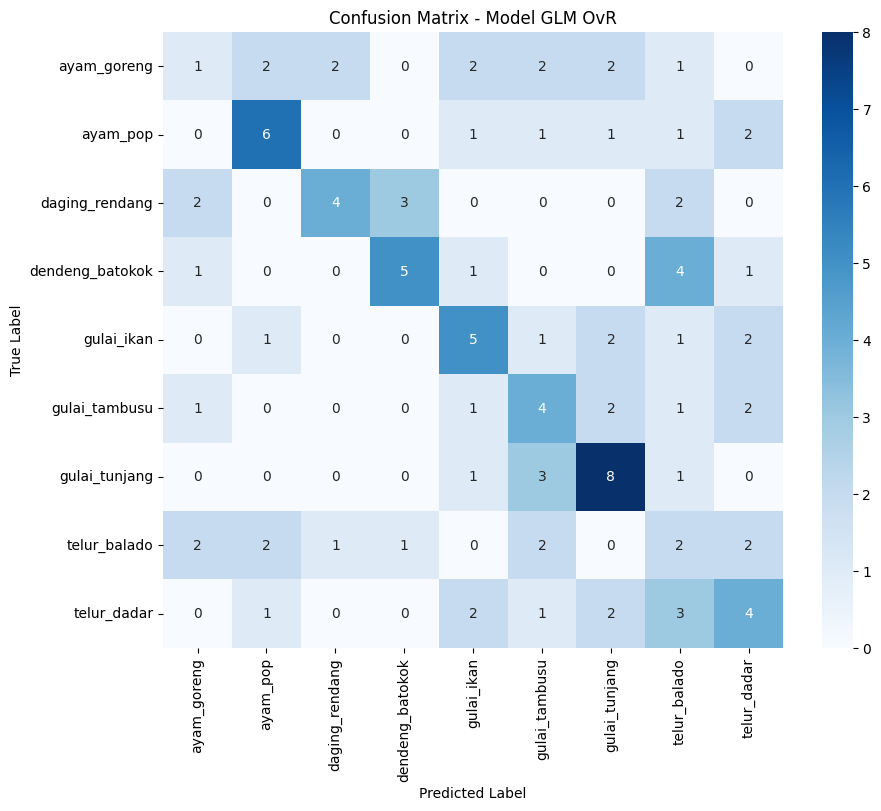

Confusion matrix disimpan di /content/drive/MyDrive/ProyekGLM_OvR_Makanan/results_glm_ovr/confusion_matrix_glm_ovr.png


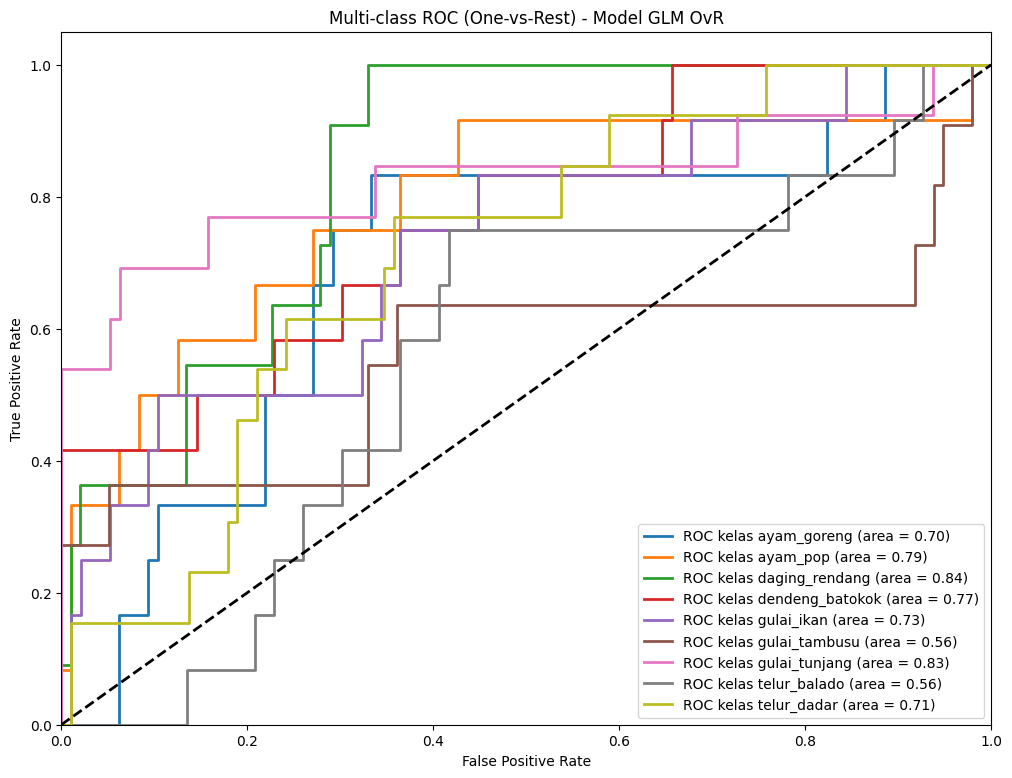

Plot ROC disimpan di /content/drive/MyDrive/ProyekGLM_OvR_Makanan/results_glm_ovr/roc_curve_glm_ovr.png

--- SECTION 7 Selesai ---


In [ ]:
# ==============================================================================
# SECTION 7: EVALUATION AND VISUALIZATION (INITIAL GLM OvR MODEL)
# ==============================================================================
print("\n--- SECTION 7: Evaluasi Model GLM OvR ---")

if training_successful and len(ovr_glm_models) > 0 and X_test_scaled_const.size > 0 and y_test_clf.size > 0 and le_clf:
    try:
        print("Memprediksi probabilitas pada data test menggunakan model GLM OvR...")
        n_samples_test = X_test_scaled_const.shape[0]
        n_classes_eval = len(le_clf.classes_)
        # Buat array untuk menyimpan probabilitas prediksi dari setiap model biner
        y_pred_proba_ovr = np.zeros((n_samples_test, n_classes_eval))

        print("Memprediksi probabilitas untuk setiap kelas:")
        for class_index, model_results in ovr_glm_models.items():
            print(f"  Memprediksi probabilitas untuk kelas '{le_clf.classes_[class_index]}' (indeks {class_index})...")
            # .predict() pada GLM Binomial mengembalikan probabilitas untuk kelas '1' (yaitu, kelas saat ini)
            try:
                 proba_c = model_results.predict(X_test_scaled_const)
                 y_pred_proba_ovr[:, class_index] = proba_c
            except Exception as e_pred:
                 print(f"    Error prediksi untuk kelas {class_index}: {e_pred}. Mengisi probabilitas dengan 0.")
                 y_pred_proba_ovr[:, class_index] = 0 # Atau nilai default lain jika prediksi gagal


        # Normalisasi probabilitas (opsional tapi direkomendasikan untuk OvR)
        # sum_probas = y_pred_proba_ovr.sum(axis=1)
        # Jika ada jumlah proba 0 (karena semua model gagal atau proba 0), hindari pembagian dengan nol
        # sum_probas[sum_probas == 0] = 1
        # y_pred_proba_ovr_normalized = y_pred_proba_ovr / sum_probas[:, np.newaxis]
        # print("Probabilitas prediksi telah dinormalisasi.")
        # Gunakan proba yang tidak dinormalisasi dulu untuk kesederhanaan:
        y_pred_proba_ovr_final = y_pred_proba_ovr

        # Dapatkan label kelas dengan probabilitas tertinggi
        y_pred_labels_ovr = np.argmax(y_pred_proba_ovr_final, axis=1)

        accuracy_ovr = accuracy_score(y_test_clf, y_pred_labels_ovr)
        print(f"\nAkurasi Model GLM OvR: {accuracy_ovr:.4f}")

        print("\nLaporan Klasifikasi Model GLM OvR:")
        class_names_report_ovr = [str(cn) for cn in le_clf.classes_]
        print(classification_report(y_test_clf, y_pred_labels_ovr, target_names=class_names_report_ovr, zero_division=0))

        # Confusion Matrix
        cm_ovr = confusion_matrix(y_test_clf, y_pred_labels_ovr, labels=le_clf.transform(le_clf.classes_))
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_ovr, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names_report_ovr, yticklabels=class_names_report_ovr)
        plt.title('Confusion Matrix - Model GLM OvR')
        plt.xlabel('Predicted Label'); plt.ylabel('True Label')
        cm_ovr_path = os.path.join(RESULTS_PATH, "confusion_matrix_glm_ovr.png")
        plt.savefig(cm_ovr_path); plt.show()
        print(f"Confusion matrix disimpan di {cm_ovr_path}")

        # ROC Curve (One-vs-Rest)
        if n_classes_eval > 1:
            fpr_ovr, tpr_ovr, roc_auc_ovr = {}, {}, {}
            ohe = OneHotEncoder(sparse_output=False)
            y_test_binarized_ovr = ohe.fit_transform(y_test_clf.reshape(-1, 1))

            plt.figure(figsize=(12, 9))
            for i in range(n_classes_eval):
                # Pastikan kolom probabilitas ada dan valid
                if y_pred_proba_ovr_final.shape[1] > i:
                    fpr_ovr[i], tpr_ovr[i], _ = roc_curve(y_test_binarized_ovr[:, i], y_pred_proba_ovr_final[:, i])
                    roc_auc_ovr[i] = auc(fpr_ovr[i], tpr_ovr[i])
                    plt.plot(fpr_ovr[i], tpr_ovr[i], lw=2,
                             label=f'ROC kelas {le_clf.classes_[i]} (area = {roc_auc_ovr[i]:.2f})')
                else:
                    print(f"Peringatan: Tidak ada probabilitas untuk kelas {i}. ROC tidak digambar.")

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
            plt.title('Multi-class ROC (One-vs-Rest) - Model GLM OvR')
            plt.legend(loc="lower right");
            roc_ovr_path = os.path.join(RESULTS_PATH, "roc_curve_glm_ovr.png")
            plt.savefig(roc_ovr_path); plt.show()
            print(f"Plot ROC disimpan di {roc_ovr_path}")
        else:
            print("Kurang dari 2 kelas, tidak dapat membuat plot ROC multi-kelas.")

    except Exception as e:
        print(f"Error saat evaluasi model GLM OvR: {e}")
        import traceback; traceback.print_exc()
else:
    print("Model GLM OvR tidak berhasil dilatih atau tidak ada data test/label encoder untuk evaluasi.")
print("\n--- SECTION 7 Selesai ---")

In [ ]:
# ==============================================================================
# SECTION 8: FINE-TUNING (MENCOBA LINK PROBIT UNTUK GLM OvR)
# ==============================================================================
print("\n--- SECTION 8: Fine-Tuning (Mencoba Link Probit untuk GLM OvR) ---")
print("Karena fine-tuning hyperparameter regularisasi tidak mudah dengan sm.GLM.fit(),")
print("kita akan mencoba konfigurasi GLM yang berbeda dengan menggunakan link 'Probit' sebagai alternatif dari 'Logit'.")

ovr_glm_models_probit = {} # Dictionary baru untuk model dengan link Probit
tuning_successful = False # Tandai apakah setidaknya satu model probit berhasil dilatih

# Pastikan data dan variabel dari section sebelumnya ada
if 'X_train_scaled_const' in locals() and X_train_scaled_const.size > 0 \
   and 'y_train_clf' in locals() and y_train_clf.size > 0 \
   and 'le_clf' in locals() and le_clf:

    n_classes = len(le_clf.classes_)
    if n_classes < 2:
        print("PERINGATAN: Hanya ada satu kelas. Tidak dapat melatih model OvR.")
    else:
        print(f"\nAkan melatih {n_classes} model GLM biner (OvR) dengan link Probit...")
        all_models_trained_probit = True

        for i, class_name in enumerate(le_clf.classes_):
            class_index = i
            print(f"\n  Melatih model PROBIT untuk kelas: '{class_name}' (indeks {class_index}) vs Rest")

            # Buat target biner
            y_train_binary = (y_train_clf == class_index).astype(int)

            if len(np.unique(y_train_binary)) < 2:
                print(f"    PERINGATAN: Target biner hanya satu nilai untuk kelas '{class_name}'. Melewati.")
                # Meskipun dilewati, kita tidak set all_models_trained_probit ke False agar proses lanjut
                # Kita hanya tidak akan punya model untuk kelas ini.
                continue

            try:
                # Inisialisasi GLM dengan keluarga Binomial DAN link Probit
                probit_link_func = sm.families.links.Probit()
                glm_model_c_probit = sm.GLM(y_train_binary,
                                            X_train_scaled_const,
                                            family=sm.families.Binomial(link=probit_link_func))

                # Latih model
                start_time_c_probit = time.time()
                # Coba tingkatkan maxiter sedikit untuk Probit jika diperlukan
                glm_results_c_probit = glm_model_c_probit.fit(maxiter=150)
                end_time_c_probit = time.time()

                if not glm_results_c_probit.converged:
                    print(f"    PERINGATAN: Model Probit untuk kelas '{class_name}' TIDAK KONVERGEN dalam {glm_results_c_probit.mle_settings['maxiter']} iterasi.")
                    # Pertimbangkan untuk tidak menyimpan model yang tidak konvergen
                    # all_models_trained_probit = False # Jika ingin menganggap kegagalan konvergensi sebagai kegagalan tuning

                print(f"    Model GLM Probit untuk kelas '{class_name}' dilatih dalam {end_time_c_probit - start_time_c_probit:.2f} detik. Converged: {glm_results_c_probit.converged}")
                ovr_glm_models_probit[class_index] = glm_results_c_probit # Simpan hasil fit

            except Exception as e:
                print(f"    ERROR saat melatih model Probit untuk kelas '{class_name}': {e}")
                import traceback; traceback.print_exc()
                all_models_trained_probit = False # Tandai ada error

        # Periksa hasil akhir dari loop tuning
        if len(ovr_glm_models_probit) > 0: # Jika setidaknya satu model berhasil dilatih
             tuning_successful = True
             print(f"\n{len(ovr_glm_models_probit)} dari {n_classes} model GLM OvR (Probit) berhasil dilatih (atau dilewati).")
             # Simpan kumpulan model Probit
             models_probit_filename = os.path.join(MODEL_PATH, "glm_ovr_models_probit.joblib")
             joblib.dump(ovr_glm_models_probit, models_probit_filename)
             print(f"Kumpulan model GLM OvR (Probit) disimpan di: {models_probit_filename}")
        else:
             print("\nPelatihan model GLM OvR (Probit) gagal untuk semua kelas.")

else:
    print("Tidak ada data training yang valid atau label encoder tidak tersedia untuk fine-tuning.")

if not tuning_successful:
     print("\nProses 'Fine-tuning' (mencoba link Probit) tidak menghasilkan model yang bisa dievaluasi.")

print("\n--- SECTION 8 Selesai ---")


--- SECTION 8: Fine-Tuning (Mencoba Link Probit untuk GLM OvR) ---
Karena fine-tuning hyperparameter regularisasi tidak mudah dengan sm.GLM.fit(),
kita akan mencoba konfigurasi GLM yang berbeda dengan menggunakan link 'Probit' sebagai alternatif dari 'Logit'.

Akan melatih 9 model GLM biner (OvR) dengan link Probit...

  Melatih model PROBIT untuk kelas: 'ayam_goreng' (indeks 0) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'ayam_goreng' dilatih dalam 28.68 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'ayam_pop' (indeks 1) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'ayam_pop' dilatih dalam 30.14 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'daging_rendang' (indeks 2) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'daging_rendang' dilatih dalam 29.91 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'dendeng_batokok' (indeks 3) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'dendeng_batokok' dilatih dalam 28.47 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'gulai_ikan' (indeks 4) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'gulai_ikan' dilatih dalam 28.62 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'gulai_tambusu' (indeks 5) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'gulai_tambusu' dilatih dalam 47.11 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'gulai_tunjang' (indeks 6) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'gulai_tunjang' dilatih dalam 28.46 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'telur_balado' (indeks 7) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'telur_balado' dilatih dalam 28.45 detik. Converged: True

  Melatih model PROBIT untuk kelas: 'telur_dadar' (indeks 8) vs Rest


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


    Model GLM Probit untuk kelas 'telur_dadar' dilatih dalam 29.69 detik. Converged: True

9 dari 9 model GLM OvR (Probit) berhasil dilatih (atau dilewati).
Kumpulan model GLM OvR (Probit) disimpan di: /content/drive/MyDrive/ProyekGLM_OvR_Makanan/models_glm_ovr/glm_ovr_models_probit.joblib

--- SECTION 8 Selesai ---



--- SECTION 9: Evaluasi Model GLM OvR Hasil 'Fine-Tuning' (Link Probit) ---
Memprediksi probabilitas pada data test menggunakan model GLM OvR (Probit)...
Memprediksi probabilitas untuk setiap kelas (model Probit):
  Memprediksi probabilitas untuk kelas 'ayam_goreng' (indeks 0)...
  Memprediksi probabilitas untuk kelas 'ayam_pop' (indeks 1)...
  Memprediksi probabilitas untuk kelas 'daging_rendang' (indeks 2)...
  Memprediksi probabilitas untuk kelas 'dendeng_batokok' (indeks 3)...
  Memprediksi probabilitas untuk kelas 'gulai_ikan' (indeks 4)...
  Memprediksi probabilitas untuk kelas 'gulai_tambusu' (indeks 5)...
  Memprediksi probabilitas untuk kelas 'gulai_tunjang' (indeks 6)...
  Memprediksi probabilitas untuk kelas 'telur_balado' (indeks 7)...
  Memprediksi probabilitas untuk kelas 'telur_dadar' (indeks 8)...

Akurasi Model GLM OvR (Probit): 0.3611

Laporan Klasifikasi Model GLM OvR (Probit):
                 precision    recall  f1-score   support

    ayam_goreng       0.14     

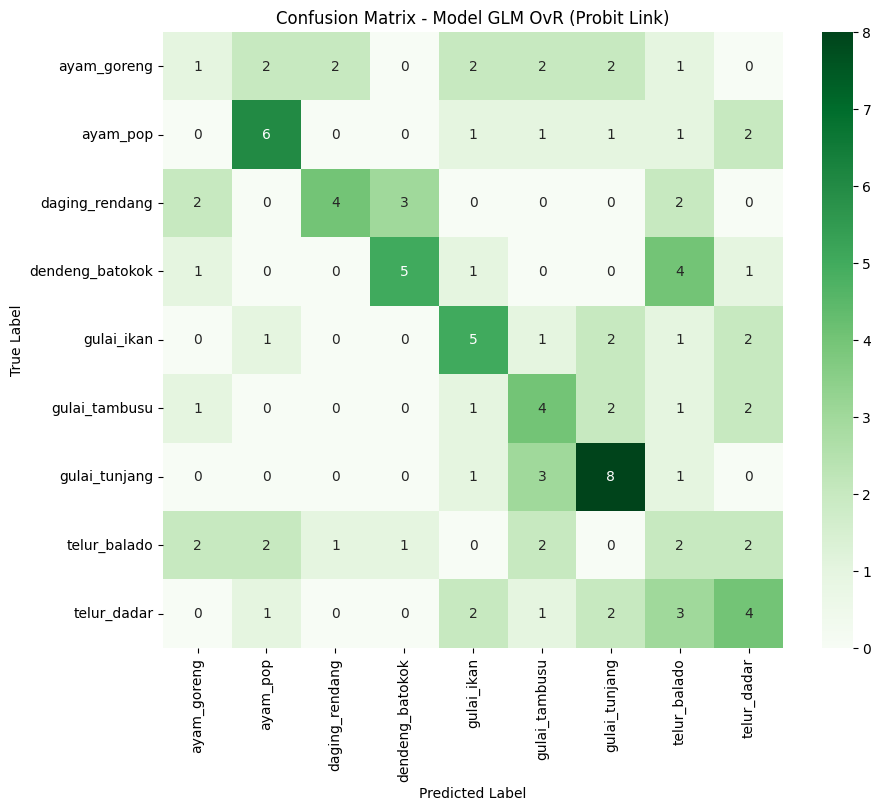

Confusion matrix (Probit) disimpan di /content/drive/MyDrive/ProyekGLM_OvR_Makanan/results_glm_ovr/confusion_matrix_glm_ovr_probit.png


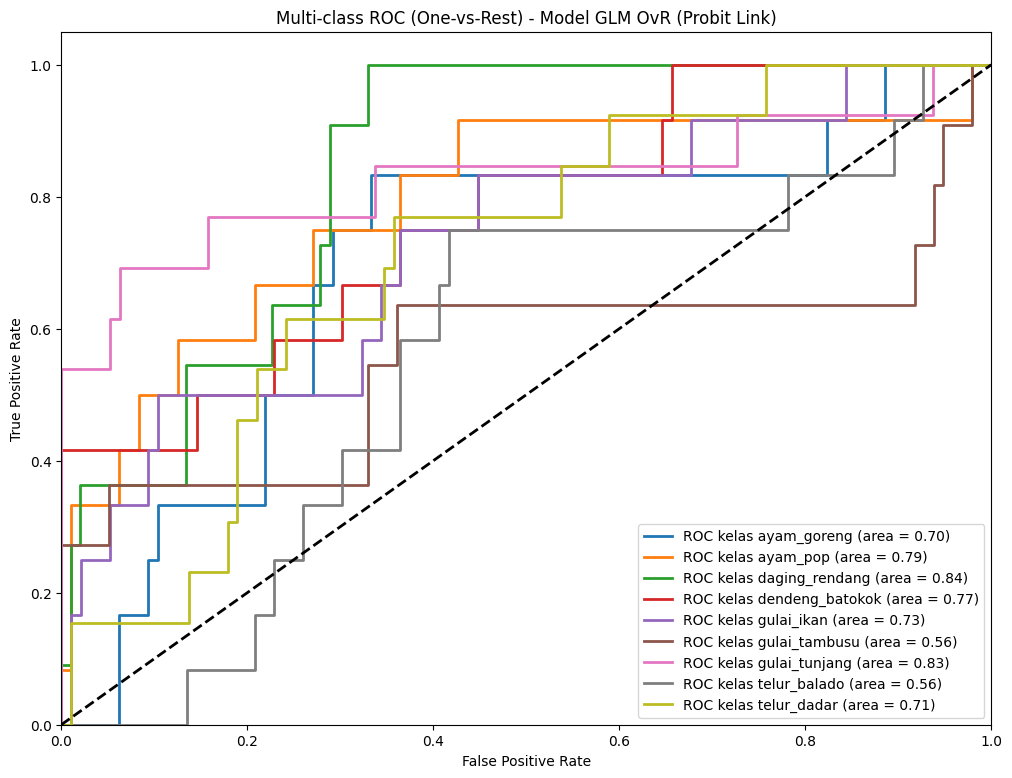

Plot ROC (Probit) disimpan di /content/drive/MyDrive/ProyekGLM_OvR_Makanan/results_glm_ovr/roc_curve_glm_ovr_probit.png

--- Perbandingan Hasil (Test Set) ---
Akurasi GLM OvR (Logit Link - dari Section 7): 0.3611
Akurasi GLM OvR (Probit Link - Section 9) : 0.3611

--- SECTION 9 Selesai ---


In [ ]:
# ==============================================================================
# SECTION 9: EVALUATION AND VISUALIZATION (MODEL HASIL 'FINE-TUNING' - PROBIT LINK)
# ==============================================================================
print("\n--- SECTION 9: Evaluasi Model GLM OvR Hasil 'Fine-Tuning' (Link Probit) ---")

# Hanya jalankan jika tuning (pelatihan model probit) berhasil
if tuning_successful and len(ovr_glm_models_probit) > 0 \
   and 'X_test_scaled_const' in locals() and X_test_scaled_const.size > 0 \
   and 'y_test_clf' in locals() and y_test_clf.size > 0 \
   and 'le_clf' in locals() and le_clf:

    try:
        print("Memprediksi probabilitas pada data test menggunakan model GLM OvR (Probit)...")
        n_samples_test = X_test_scaled_const.shape[0]
        n_classes_eval = len(le_clf.classes_)
        y_pred_proba_ovr_probit = np.zeros((n_samples_test, n_classes_eval))

        print("Memprediksi probabilitas untuk setiap kelas (model Probit):")
        # Gunakan model yang disimpan di ovr_glm_models_probit
        missing_models = False
        for i in range(n_classes_eval):
            if i in ovr_glm_models_probit:
                 model_results_probit = ovr_glm_models_probit[i]
                 print(f"  Memprediksi probabilitas untuk kelas '{le_clf.classes_[i]}' (indeks {i})...")
                 try:
                     proba_c_probit = model_results_probit.predict(X_test_scaled_const)
                     y_pred_proba_ovr_probit[:, i] = proba_c_probit
                 except Exception as e_pred_probit:
                     print(f"    Error prediksi Probit untuk kelas {i}: {e_pred_probit}. Mengisi probabilitas dengan 0.")
                     y_pred_proba_ovr_probit[:, i] = 0
            else:
                 print(f"  Model Probit untuk kelas '{le_clf.classes_[i]}' (indeks {i}) tidak tersedia (mungkin gagal training). Mengisi probabilitas dengan 0.")
                 y_pred_proba_ovr_probit[:, i] = 0
                 missing_models = True

        if missing_models:
             print("PERINGATAN: Beberapa model kelas tidak tersedia, hasil evaluasi mungkin tidak akurat.")

        # Dapatkan label kelas dengan probabilitas tertinggi
        y_pred_labels_ovr_probit = np.argmax(y_pred_proba_ovr_probit, axis=1)

        accuracy_ovr_probit = accuracy_score(y_test_clf, y_pred_labels_ovr_probit)
        print(f"\nAkurasi Model GLM OvR (Probit): {accuracy_ovr_probit:.4f}")

        print("\nLaporan Klasifikasi Model GLM OvR (Probit):")
        # Gunakan class_names_report_ovr dari Section 7 jika sudah didefinisikan
        if 'class_names_report_ovr' not in locals():
            class_names_report_ovr = [str(cn) for cn in le_clf.classes_] # Buat jika belum ada
        print(classification_report(y_test_clf, y_pred_labels_ovr_probit, target_names=class_names_report_ovr, zero_division=0))

        # Confusion Matrix
        cm_ovr_probit = confusion_matrix(y_test_clf, y_pred_labels_ovr_probit, labels=le_clf.transform(le_clf.classes_))
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_ovr_probit, annot=True, fmt='d', cmap='Greens', # Ganti warna peta
                    xticklabels=class_names_report_ovr, yticklabels=class_names_report_ovr)
        plt.title('Confusion Matrix - Model GLM OvR (Probit Link)')
        plt.xlabel('Predicted Label'); plt.ylabel('True Label')
        cm_ovr_probit_path = os.path.join(RESULTS_PATH, "confusion_matrix_glm_ovr_probit.png")
        plt.savefig(cm_ovr_probit_path); plt.show()
        print(f"Confusion matrix (Probit) disimpan di {cm_ovr_probit_path}")

        # ROC Curve (One-vs-Rest)
        if n_classes_eval > 1:
            fpr_ovr_p, tpr_ovr_p, roc_auc_ovr_p = {}, {}, {}
            # Gunakan y_test_binarized_ovr dari Section 7 jika sudah didefinisikan
            if 'y_test_binarized_ovr' not in locals():
                 ohe = OneHotEncoder(sparse_output=False)
                 y_test_binarized_ovr = ohe.fit_transform(y_test_clf.reshape(-1, 1))

            plt.figure(figsize=(12, 9))
            for i in range(n_classes_eval):
                if y_pred_proba_ovr_probit.shape[1] > i and i in ovr_glm_models_probit: # Hanya plot jika model probit ada
                    fpr_ovr_p[i], tpr_ovr_p[i], _ = roc_curve(y_test_binarized_ovr[:, i], y_pred_proba_ovr_probit[:, i])
                    roc_auc_ovr_p[i] = auc(fpr_ovr_p[i], tpr_ovr_p[i])
                    plt.plot(fpr_ovr_p[i], tpr_ovr_p[i], lw=2,
                             label=f'ROC kelas {le_clf.classes_[i]} (area = {roc_auc_ovr_p[i]:.2f})')
                # else: # Tidak perlu pesan error lagi di sini
                #    pass

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
            plt.title('Multi-class ROC (One-vs-Rest) - Model GLM OvR (Probit Link)')
            plt.legend(loc="lower right");
            roc_ovr_probit_path = os.path.join(RESULTS_PATH, "roc_curve_glm_ovr_probit.png")
            plt.savefig(roc_ovr_probit_path); plt.show()
            print(f"Plot ROC (Probit) disimpan di {roc_ovr_probit_path}")
        else:
            print("Kurang dari 2 kelas, tidak dapat membuat plot ROC multi-kelas.")

        # --- Perbandingan dengan Model Awal (Logit Link) ---
        print("\n--- Perbandingan Hasil (Test Set) ---")
        print(f"Akurasi GLM OvR (Logit Link - dari Section 7): {accuracy_ovr:.4f}" if 'accuracy_ovr' in locals() else "Akurasi Logit tidak tersedia.")
        print(f"Akurasi GLM OvR (Probit Link - Section 9) : {accuracy_ovr_probit:.4f}")
        # Anda bisa menambahkan perbandingan metrik lain jika diinginkan

    except Exception as e:
        print(f"Error saat evaluasi model GLM OvR (Probit): {e}")
        import traceback; traceback.print_exc()
elif not tuning_successful:
     print("Proses 'Fine-tuning' (mencoba link Probit) tidak berhasil atau tidak menghasilkan model. Evaluasi Section 9 dilewati.")
else:
    print("Data test tidak tersedia atau komponen lain hilang. Evaluasi Section 9 dilewati.")

print("\n--- SECTION 9 Selesai ---")

In [ ]:
# ==============================================================================
# SECTION 10: INFERENCE (Memilih Model GLM OvR Terbaik atau Default ke Logit)
# ==============================================================================
print("\n--- SECTION 10: Inferensi ---")

# Pilih model mana yang akan digunakan untuk inferensi
# Untuk contoh ini, kita gunakan model Probit jika akurasinya lebih baik, jika tidak gunakan Logit (jika ada)
final_ovr_models_to_use = None
model_choice = "Tidak ada model yang tersedia."

# Ambil akurasi dari context jika ada
logit_accuracy = locals().get('accuracy_ovr', -1)
probit_accuracy = locals().get('accuracy_ovr_probit', -1)

if probit_accuracy > logit_accuracy and tuning_successful and len(ovr_glm_models_probit) > 0:
    final_ovr_models_to_use = ovr_glm_models_probit
    model_choice = "Probit Link (hasil 'tuning')"
    print(f"Menggunakan model GLM OvR dengan {model_choice} untuk inferensi (Akurasi Test: {probit_accuracy:.4f}).")
elif logit_accuracy != -1 and 'ovr_glm_models' in locals() and len(ovr_glm_models) > 0:
    final_ovr_models_to_use = ovr_glm_models
    model_choice = "Logit Link (model awal)"
    print(f"Menggunakan model GLM OvR dengan {model_choice} untuk inferensi (Akurasi Test: {logit_accuracy:.4f}).")
elif tuning_successful and len(ovr_glm_models_probit) > 0: # Fallback ke probit jika logit tidak ada tapi probit ada
    final_ovr_models_to_use = ovr_glm_models_probit
    model_choice = "Probit Link (hanya ini yang tersedia)"
    print(f"Menggunakan model GLM OvR dengan {model_choice} untuk inferensi (Akurasi Test: {probit_accuracy:.4f}).")
else:
     print("Tidak ada model GLM OvR yang berhasil dilatih yang tersedia untuk inferensi.")


if final_ovr_models_to_use and 'scaler_glm_ovr' in locals() and scaler_glm_ovr and 'le_clf' in locals() and le_clf:
    # Fungsi preprocess_single_image_for_glm_ovr_inference dan predict_image_class_glm_ovr sudah didefinisikan di Section 10 pada kode GLM OvR sebelumnya
    # Pastikan definisi fungsi tersebut ada di sini atau panggil dari konteks sebelumnya.
    # Untuk kejelasan, kita definisikan ulang di sini:
    def preprocess_single_image_for_glm_ovr_inference(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
        try:
            img = Image.open(image_path).convert('L').resize(target_size)
            flattened_img = np.array(img).flatten().reshape(1, -1)
            scaled_img = scaler_glm_ovr.transform(flattened_img.astype(np.float32))
            scaled_img_const = sm.add_constant(scaled_img, has_constant='add')
            return scaled_img_const
        except Exception as e:
            print(f"Error memproses gambar inferensi {image_path}: {e}")
            return None

    def predict_image_class_glm_ovr(image_path, ovr_models_dict, label_encoder):
        processed_image_const = preprocess_single_image_for_glm_ovr_inference(image_path)
        if processed_image_const is None: return None, None, None
        n_classes_inf = len(label_encoder.classes_)
        pred_probas_inf = np.zeros(n_classes_inf)
        print(f"Inferensi menggunakan model {model_choice}:")
        for class_index, model_results in ovr_models_dict.items():
             # Pastikan class_index valid untuk label_encoder
             if class_index < len(label_encoder.classes_):
                 print(f"  Prediksi proba kelas '{label_encoder.classes_[class_index]}'...")
                 try:
                     proba_c = model_results.predict(processed_image_const)[0]
                     pred_probas_inf[class_index] = proba_c
                 except Exception as e_inf_pred:
                     print(f"    Error prediksi kelas {class_index}: {e_inf_pred}. Proba diisi 0.")
                     pred_probas_inf[class_index] = 0
             else:
                  print(f"  Peringatan: Indeks kelas {class_index} dari model tidak valid untuk label encoder. Dilewati.")


        predicted_label_index = np.argmax(pred_probas_inf)
        predicted_class_name = label_encoder.inverse_transform([predicted_label_index])[0]
        confidence = pred_probas_inf[predicted_label_index]
        return predicted_class_name, confidence, pred_probas_inf

    # Contoh inferensi (ambil path gambar dari konteks sebelumnya jika ada)
    example_image_path_final = locals().get('example_image_path_glm_ovr', None) # Gunakan path dari percobaan sebelumnya jika ada

    if example_image_path_final and os.path.exists(example_image_path_final):
        print(f"\nMelakukan inferensi pada gambar contoh: {example_image_path_final}")
        try:
            img_display = Image.open(example_image_path_final)
            plt.imshow(img_display); plt.title(f"Inferensi ({model_choice})"); plt.axis('off'); plt.show()

            predicted_class, confidence, all_probas = predict_image_class_glm_ovr(example_image_path_final, final_ovr_models_to_use, le_clf)
            if predicted_class:
                print(f"  Prediksi Kelas: {predicted_class}")
                if confidence is not None: print(f"  Keyakinan (Confidence): {confidence:.4f}")
                if all_probas is not None:
                    print("  Probabilitas untuk semua kelas:")
                    for i, class_name_le in enumerate(le_clf.classes_): print(f"    - {class_name_le}: {all_probas[i]:.4f}")
            else: print("  Gagal melakukan prediksi.")
        except Exception as e_inf: print(f"Error saat inferensi: {e_inf}")
    else: print("Tidak ada gambar contoh valid untuk inferensi.")

else:
    print("Komponen yang diperlukan untuk inferensi (model, scaler, atau label encoder) tidak tersedia.")

print("\n--- SECTION 10 Selesai ---")


--- SECTION 10: Inferensi ---
Menggunakan model GLM OvR dengan Logit Link (model awal) untuk inferensi (Akurasi Test: 0.3611).
Tidak ada gambar contoh valid untuk inferensi.

--- SECTION 10 Selesai ---
